In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications import MobileNet

In [10]:
img_height, img_width = (200, 200)
IMG_SIZE = (img_height, img_width)
batch_size = 32

data_directory = "dataset"

In [29]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="training",
    validation_split=0.1,
    seed=69420,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

Found 685 files belonging to 8 classes.
Using 617 files for training.


In [12]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_directory,
    subset="validation",
    validation_split=0.1,
    seed=69420,
    image_size=IMG_SIZE,
    batch_size=batch_size
)

Found 685 files belonging to 8 classes.
Using 68 files for validation.


In [13]:
train_data.class_names

['1_polyethylene_PET',
 '2_high_density_polyethylene_PE-HD',
 '3_polyvinylchloride_PVC',
 '4_low_density_polyethylene_PE-LD',
 '5_polypropylene_PP',
 '6_polystyrene_PS',
 '7_other_resins',
 '8_no_plastic']

In [26]:
class_names = train_data.class_names

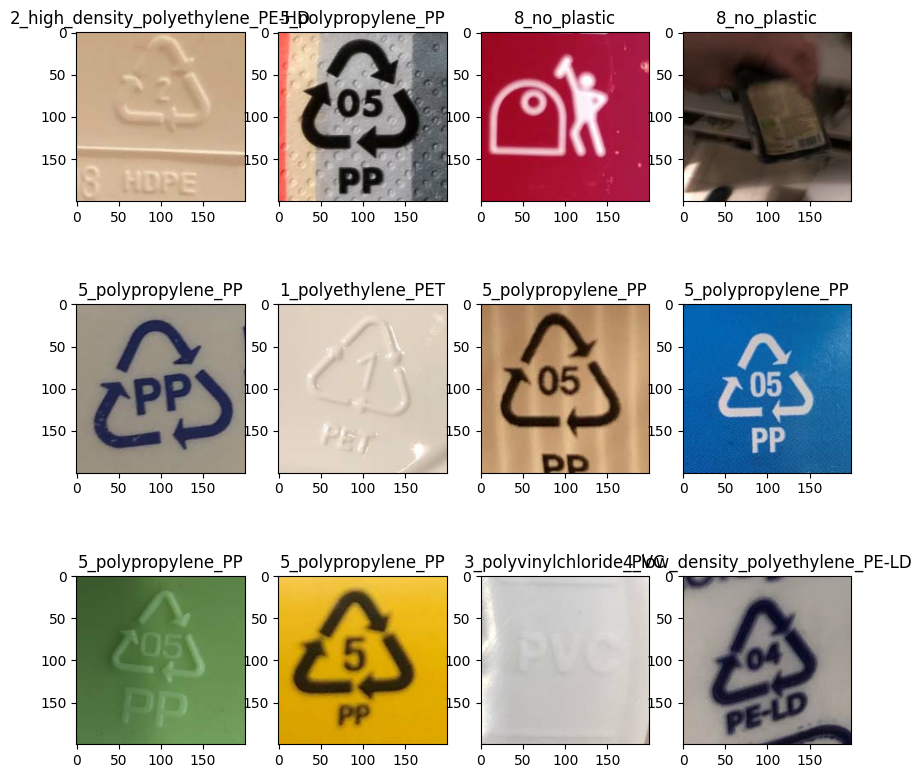

In [28]:
image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10,10))
for i in range (12):
    ax = plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = class_names[label_batch[i]]
    plt.title(label)


In [44]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.experimental.preprocessing.RandomRotation(40),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [45]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [50]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE+(3,),
    include_top=False,
    weights="imagenet"                          
)
base_model.trainable = True

In [51]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [52]:
feature_batch_avg = tf.keras.layers.GlobalAveragePooling2D()(feature_batch)
print(feature_batch_avg.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)